In [1]:
import anndata
import numpy as np
import scvelo as scv
import scanpy as sc
import sys
import torch
import os.path
sys.path.append('../')
import velovae as vv

# Load Input Data

In [2]:
dataset = "Pancreas"
adata = scv.datasets.pancreas()

In [3]:
model_path_base = f"checkpoints/{dataset}"
figure_path_base = f"figures/{dataset}"
data_path_base = f"data/{dataset}"

# Preprocessing

In [4]:
Ngene = 2000
vv.preprocess(adata, Ngene)

Filtered out 22645 genes that are detected 50 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


# (Optional) Run scVelo

saving figure to file figures/Pancreas/umap.png


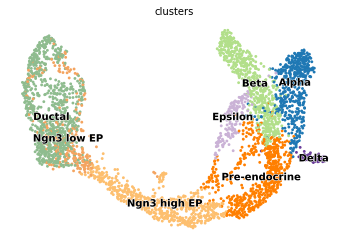

In [5]:
os.makedirs(figure_path_base, exist_ok=True)
scv.pl.scatter(adata, basis='umap', save=figure_path_base+"/umap.png")

In [6]:
scv.tl.recover_dynamics(adata)
scv.tl.latent_time(adata)

recovering dynamics (using 1/40 cores)


  0%|          | 0/1225 [00:00<?, ?gene/s]

    finished (0:09:37) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/40 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


# Train a VeloVAE Basic Model
The basic model assumes fixed transcription rates.

In [7]:
figure_path = figure_path_base+"/VanillaVAE"
model_path = model_path_base+"/VanillaVAE"
data_path = data_path_base

In [8]:
def sampleGenes(adata, n, key, mode='top',q=0.5):
    if(mode=='random'):
        return np.random.choice(adata.var_names, n, replace=False)
    val_sorted = adata.var[key].sort_values(ascending=False)
    genes_sorted = val_sorted.index.to_numpy()
    if(mode=='threshold'):
        N = np.sum(val_sorted.to_numpy()>=q)
        return np.random.choice(genes_sorted[:N], min(n,N), replace=False)
    return genes_sorted[:n]
gene_plot = sampleGenes(adata, 4, 'fit_likelihood', 'top')
gene_plot

array(['Pcsk2', 'Dcdc2a', 'Ank', 'Gng12'], dtype=object)

In [9]:
torch.manual_seed(42)
np.random.seed(42)
config = {
    #Model Parameters
    "tmax":20,
    "hidden_size":(500,250),
    "init_method":"steady",
    "init_key":None,
    "tprior":None,
    #Training Parameters
    "N_epochs":500, 
    "N_warmup":5,
    "learning_rate":2e-4, 
    "learning_rate_ode":2e-4, 
    "lambda":1e-3,  
    "batch_size":128,
    "train_test_split":0.7,
}

vae = vv.VanillaVAE(adata, 
                    config['tmax'], 
                    hidden_size=config['hidden_size'], 
                    device='cuda:0',
                    tprior=config['tprior'], 
                    init_method=config['init_method'],
                    init_key=config['init_key'])

Initialization using the steady-state and dynamical models.


In [10]:
vae.train(adata, config=config, gene_plot=gene_plot, figure_path=figure_path)

------------------------- Train a Vanilla VAE -------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
Total Number of Iterations Per Epoch: 21
Epoch 1: Train MSE = 35.590, Test MSE = 34.994, 	 Total Time =   0 h :  0 m : 11 s
Epoch 100: Train MSE = 18.193, Test MSE = 17.061, 	 Total Time =   0 h :  1 m : 33 s
Epoch 200: Train MSE = 13.196, Test MSE = 12.029, 	 Total Time =   0 h :  2 m : 53 s
Epoch 300: Train MSE = 11.003, Test MSE = 9.773, 	 Total Time =   0 h :  4 m : 17 s
Epoch 400: Train MSE = 10.531, Test MSE = 9.305, 	 Total Time =   0 h :  5 m : 45 s
Epoch 500: Train MSE = 10.525, Test MSE = 9.333, 	 Total Time =   0 h :  7 m : 18 s
*********             

In [12]:
vae.saveModel(model_path, "encoder_vanilla","decoder_vanilla")
vae.saveAnnData(adata, 'vanilla', data_path, file_name="pancreas_out.h5ad")

In [13]:
with open(figure_path+'/config.txt','w') as f:
    for key in vae.config:
        f.write(key+'\t'+str(vae.config[key])+'\n')

# Train a VeloVAE Model

In [14]:
figure_path = figure_path_base+"/VAE"
model_path = model_path_base+"/VAE"
data_path = data_path_base

In [15]:
torch.manual_seed(42)
np.random.seed(42)
config = {
    "tmax":20,
    "Cz":5,
    "hidden_size":(500, 250, 250, 500),
    "init_method": "steady",
    "init_key": None,
    "tprior":None,
    "n_neighbors":15,
    "dt": (0.03,0.06),
    #Training Parameters
    "N_epochs":250,
    "N_epochs_post":250,
    "N_warmup":5,
    "N_warmup_post":5,
    "learning_rate":2e-4, 
    "learning_rate_ode":2e-4, 
    "learning_rate_post":2e-4,
    "lambda":1e-3,
    "lambda_rho":1e-3,
    "reg_t":1.0, 
    "reg_z":1.0, 
    "neg_slope":0.0, 
    "batch_size":128,
    "train_test_split":0.7
}
model = vv.VanillaVAEpp(adata, 
                        config['tmax'], 
                        config['Cz'], 
                        device='cuda:0', 
                        hidden_size=config['hidden_size'], 
                        init_method=config["init_method"],
                        init_key=config["init_key"],
                        tprior=config['tprior'])


Initialization using the steady-state and dynamical models.


In [16]:
model.train(adata, config=config, plot=True, gene_plot=gene_plot, figure_path=figure_path)

--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 21
Epoch 1: Train MSE = 21.144, Test MSE = 20.112, 	 Total Time =   0 h :  0 m :  8 s
Epoch 100: Train MSE = 5.950, Test MSE = 5.193, 	 Total Time =   0 h :  1 m : 23 s
Epoch 200: Train MSE = 2.347, Test MSE = 2.022, 	 Total Time =   0 h :  2 m : 41 s
*********                      Stage  2                       *********
Epoch 251: Train MSE = 6.345201015472412, Test MSE = 6.073051452636719, 	 Total Time =   0 h :  3 m : 33 s
Epoch 350: Train MSE = 2.75

In [17]:
model.saveModel(model_path, 'encoder_vae', 'decoder_vae')
model.saveAnnData(adata, 'vae', data_path, file_name="pancreas_out.h5ad")

In [18]:
with open(figure_path+'/config.txt','w') as f:
    for key in model.config:
        f.write(key+'\t'+str(model.config[key])+'\n')

# Post Analysis
## Compute the Metrics and Plot the Genes

In [19]:
methods = ['scVelo', 'Vanilla VAE', 'VeloVAE']
keys = ['fit','vanilla','vae']
plot_type = ["signal","time"]
grid_size = (2,2)
vv.postAnalysis(adata, methods, keys, gene_plot, plot_type, Nplot=100, embed="umap", grid_size=grid_size, save_path=figure_path_base)

---     Post Analysis     ---
Dataset Size: 3696 cells, 2000 genes
           scVelo  Vanilla VAE   VeloVAE
MSE Train   2.107       6.8147    0.7596
MAE Train  0.4229       0.3564    0.1940
MSE Test      N/A       5.1627    0.5947
MAE Test      N/A       0.3505    0.1938
LL Train    -1702     271.7133  752.4920
LL Test       N/A     274.6817  744.4283
corr       0.2472       0.8907    0.9055
---   Plotting  Results   ---
Saved to figures/Pancreas/time.png
Saved to figures/Pancreas/sig_test_1.png


## Other Results

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'lime', 'grey', \
   'olive', 'cyan', 'pink', 'gold', 'steelblue', 'salmon', 'teal', \
   'magenta', 'rosybrown', 'darkorange', 'yellow', 'greenyellow', 'darkseagreen', 'yellowgreen', 'palegreen', \
   'hotpink', 'navajowhite', 'aqua', 'navy', 'saddlebrown', 'black', 'maroon']
key = 'vae'
z = adata.obsm[f'{key}_z']
t = adata.obs[f'{key}_time'].to_numpy()
t0 = adata.obs[f'{key}_t0'].to_numpy()
U0 = adata.layers[f'{key}_u0']
S0 = adata.layers[f'{key}_s0']
rho = adata.layers[f'{key}_rho']
V = adata.layers[f"{key}_velocity"]
Uhat = adata.layers[f"{key}_uhat"]
Shat = adata.layers[f"{key}_shat"]

cell_labels = adata.obs['clusters'].to_numpy()
cell_types = np.unique(cell_labels)

## Result 1: Transcription Rate $\rho$

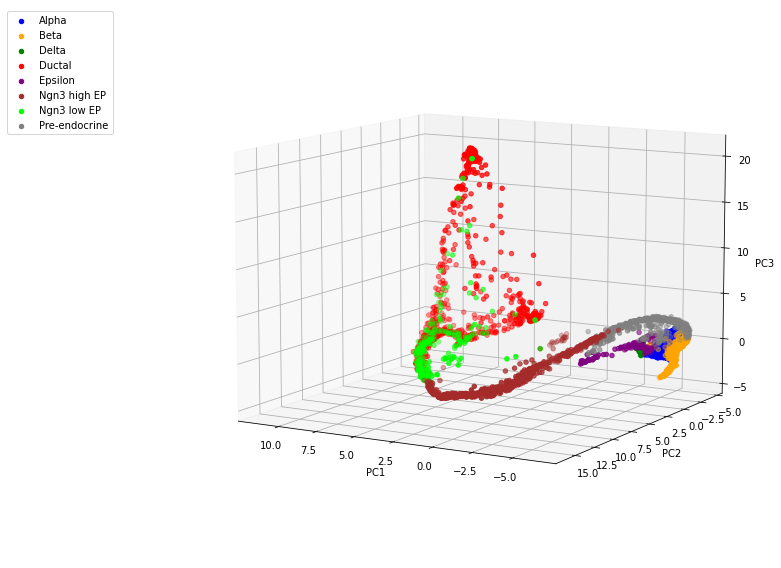

In [21]:
pca = PCA(n_components=3)
rho_pca = pca.fit_transform(rho)

fig=plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
ax.view_init(10, 120)
for i,x in enumerate((cell_types)):
    ax.scatter(rho_pca[cell_labels==x,0], rho_pca[cell_labels==x,1], rho_pca[cell_labels==x,2], label=x, color=colors[i])
    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.legend(bbox_to_anchor=(-0.15,1.0), loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig(figure_path_base+'/rho_pca.png')

## Result 2: Latent Embedding

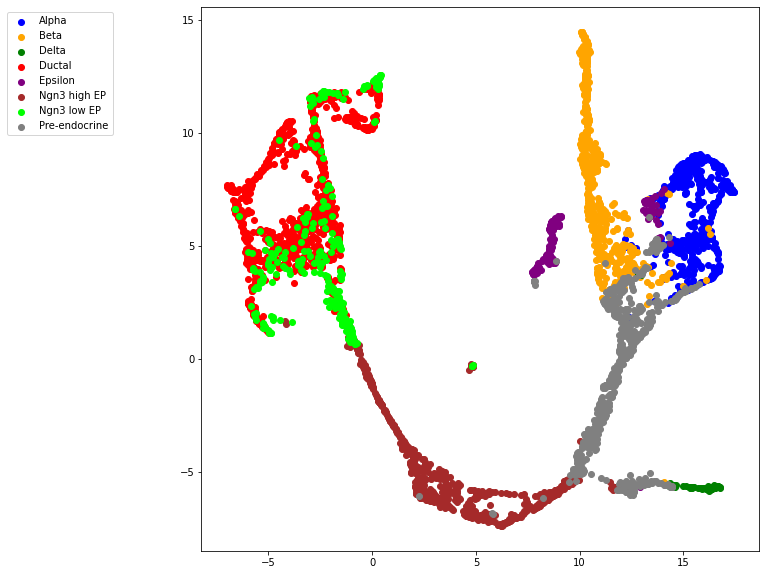

In [22]:
umap_obj = umap.UMAP(n_neighbors=30, n_components=2, min_dist=0.25)
z_umap = umap_obj.fit_transform(z)

fig=plt.figure(figsize=(10,10))
for i,x in enumerate((cell_types)):
    plt.scatter(z_umap[cell_labels==x,0], z_umap[cell_labels==x,1], label=x, color=colors[i])
plt.legend(bbox_to_anchor=(-0.15,1.0), loc='upper right')
plt.show()
fig.savefig(figure_path_base+'/z_umap.png')

## Result 3: Velocity Stream Plot

computing velocities
    finished (0:00:06) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/40 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file figures/Pancreas/Pancreas_velocity_scv.png


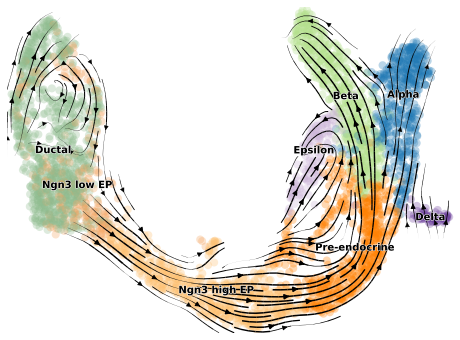

In [24]:
import scvelo as scv
scv.tl.velocity(adata, vkey='velocity', mode='dynamical')
scv.tl.velocity_graph(adata, vkey='velocity')
scv.tl.velocity_embedding(adata, vkey='velocity')
scv.pl.velocity_embedding_stream(adata, vkey='velocity', figsize=(8,6), title="", save=f'{figure_path_base}/{dataset}_velocity_scv.png')

computing velocity graph (using 1/40 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:32) --> added 
    'vanilla_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vanilla_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file figures/Pancreas/Pancreas_velocity_vae.png


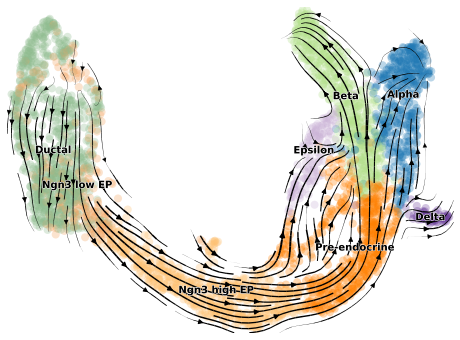

In [25]:
key = 'vanilla'
vv.rnaVelocityVAE(adata, key, use_scv_genes=False)
scv.tl.velocity_graph(adata, vkey=f'{key}_velocity')
scv.tl.velocity_embedding(adata, vkey=f'{key}_velocity')
scv.pl.velocity_embedding_stream(adata, vkey=f'{key}_velocity', title="", figsize=(8,6), save=f'{figure_path_base}/{dataset}_velocity_vae.png')

computing velocity graph (using 1/40 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:33) --> added 
    'vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vae_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file figures/Pancreas/Pancreas_velocity_vae.png


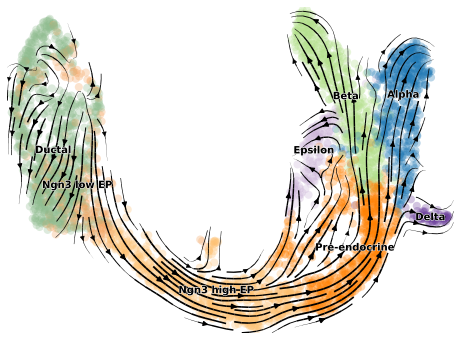

In [26]:
key = 'vae'
vv.rnaVelocityVAEpp(adata, key, use_scv_genes=False, sigma=None, approx=False)
scv.tl.velocity_graph(adata, vkey=f'{key}_velocity')
scv.tl.velocity_embedding(adata, vkey=f'{key}_velocity')
scv.pl.velocity_embedding_stream(adata, vkey=f'{key}_velocity', title="", figsize=(8,6), save=f'{figure_path_base}/{dataset}_velocity_{key}.png')

In [27]:
adata.write_h5ad(data_path_base+"/pancreas_out.h5ad")